<div align="center">
<p align="center" style="width: 100%;">
    <img src="https://raw.githubusercontent.com/vlm-run/.github/refs/heads/main/profile/assets/vlm-black.svg" alt="VLM Run Logo" width="80" style="margin-bottom: -5px; color: #2e3138; vertical-align: middle; padding-right: 5px;"><br>
</p>
<p align="center"><a href="https://docs.vlm.run"><b>Website</b></a> | <a href="https://docs.vlm.run/"><b>API Docs</b></a> | <a href="https://docs.vlm.run/blog"><b>Blog</b></a> | <a href="https://discord.gg/AMApC2UzVY"><b>Discord</b></a>
</p>
<p align="center">
<a href="https://discord.gg/AMApC2UzVY"><img alt="Discord" src="https://img.shields.io/badge/discord-chat-purple?color=%235765F2&label=discord&logo=discord"></a>
<a href="https://twitter.com/vlmrun"><img alt="Twitter Follow" src="https://img.shields.io/twitter/follow/vlmrun.svg?style=social&logo=twitter"></a>
</p>
</div>

Welcome to **[VLM Run Cookbooks](https://github.com/vlm-run/vlmrun-cookbook)**, a comprehensive collection of examples and notebooks demonstrating the power of structured visual understanding using the [VLM Run Platform](https://app.vlm.run). 

## 🤓 Case Study: US Driver License Extraction

In this notebook, we'll walk through an example of extracting structured data from US driver license images using VLM Run.

### Environment Setup

To get started, install the VLM Run Python SDK and sign-up for an API key on the [VLM Run App](https://app.vlm.run).
- Store the VLM Run API key under the `VLMRUN_API_KEY` environment variable.

## Prerequisites

* Python 3.9+
* VLM Run API key (get one at [app.vlm.run](https://app.vlm.run))

## Setup

First, let's install the required packages:

In [1]:
! pip install vlmrun --upgrade --quiet
! pip install vlmrun-hub --upgrade --quiet

In [2]:
from dotenv import load_dotenv

load_dotenv()

True

In [3]:
! pip install pandas google-cloud-storage openai --quiet

In [4]:
import os
import getpass

VLMRUN_BASE_URL = os.getenv("VLMRUN_BASE_URL", "https://dev.vlm.run/v1")
VLMRUN_API_KEY = os.getenv("VLMRUN_API_KEY", None)
if VLMRUN_API_KEY is None:
    VLMRUN_API_KEY = getpass.getpass()

In [5]:
import pandas as pd
from PIL import Image

from vlmrun.common.image import encode_image
from vlmrun.common.utils import remote_image
from pathlib import Path
from google.cloud import storage

In [6]:
BUCKET_NAME = "vlm-data-public-prod"
PREFIX = "hub/examples/document.us-drivers-license/us-dataset-2025-01-22"

storage_client = storage.Client.create_anonymous_client()
bucket = storage_client.bucket(BUCKET_NAME)
blobs = bucket.list_blobs(prefix=PREFIX)

image_urls = [
    f"https://storage.googleapis.com/{BUCKET_NAME}/{blob.name}"
    for blob in blobs
    if any(blob.name.lower().endswith(ext) for ext in ['.jpg', '.jpeg', '.png'])
]

In [7]:
df = pd.DataFrame({
    "image_path": image_urls,
    "image": [remote_image(url) for url in image_urls]
})

print(f"Loaded {len(image_urls)} driver's license images")
df.head()

Loaded 54 driver's license images


,image_path,image
0,https://storage.googleapis.com/vlm-data-public...,<PIL.Image.Image image mode=RGB size=650x406 a...
1,https://storage.googleapis.com/vlm-data-public...,<PIL.Image.Image image mode=RGB size=514x328 a...
2,https://storage.googleapis.com/vlm-data-public...,<PIL.Image.Image image mode=RGB size=700x439 a...
3,https://storage.googleapis.com/vlm-data-public...,<PIL.Image.Image image mode=RGB size=700x450 a...
4,https://storage.googleapis.com/vlm-data-public...,<PIL.Image.Image image mode=RGB size=700x448 a...


,image_path,image
0,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/Alabama.jpg,
1,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/Alaska.jpg,
2,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/Arizona.jpg,
3,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/Arkansas.jpg,
4,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/California.jpg,
5,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/Colorado.jpg,
6,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/Connecticut.jpg,
7,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/Delaware.jpg,
8,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/Florida.jpg,
9,https://storage.googleapis.com/vlm-data-public-prod/hub/examples/document.us-drivers-license/us-dataset-2025-01-22/Georgia.jpg,

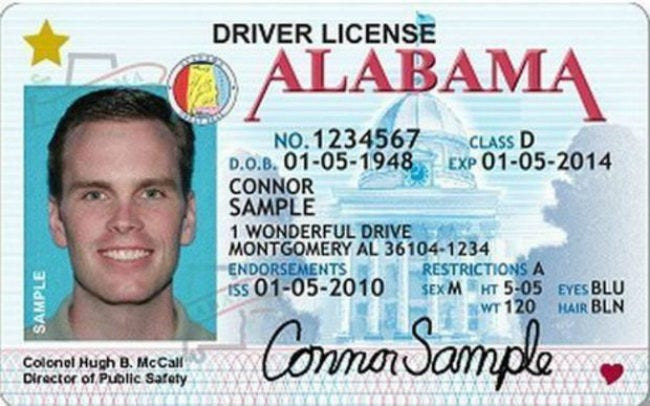
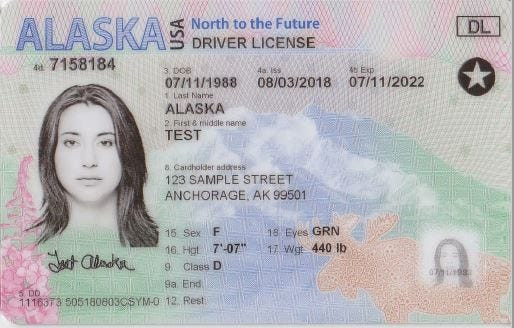
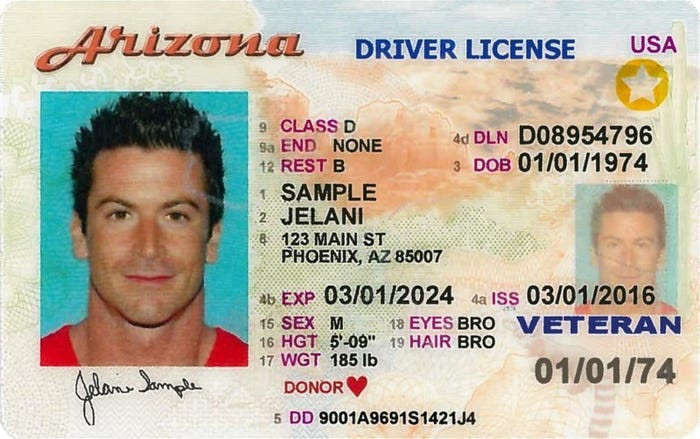
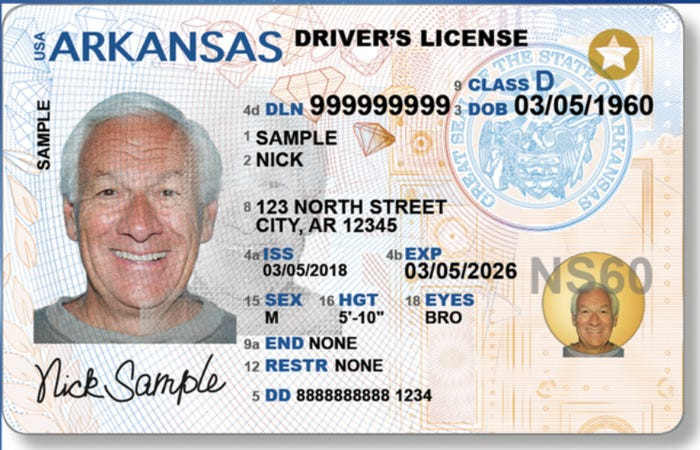
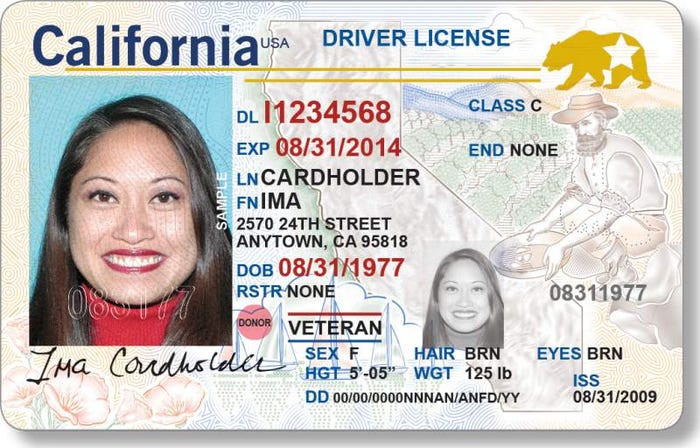
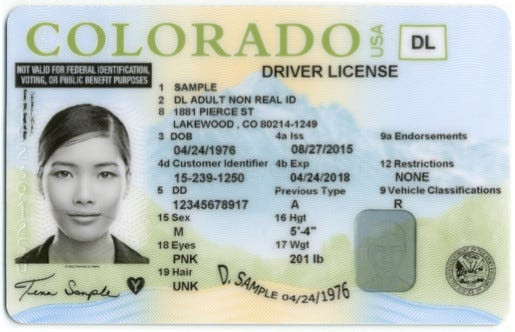
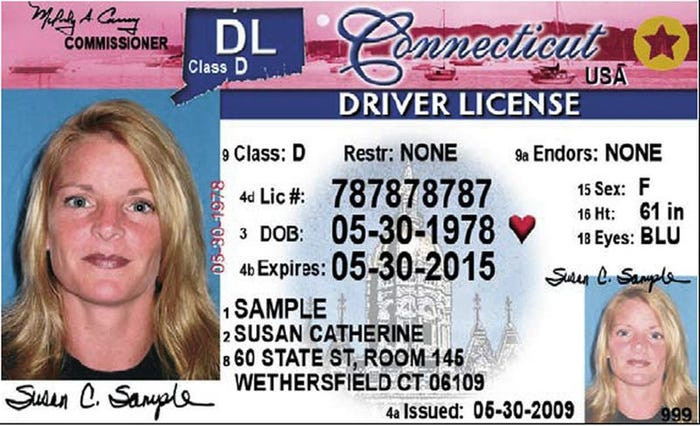
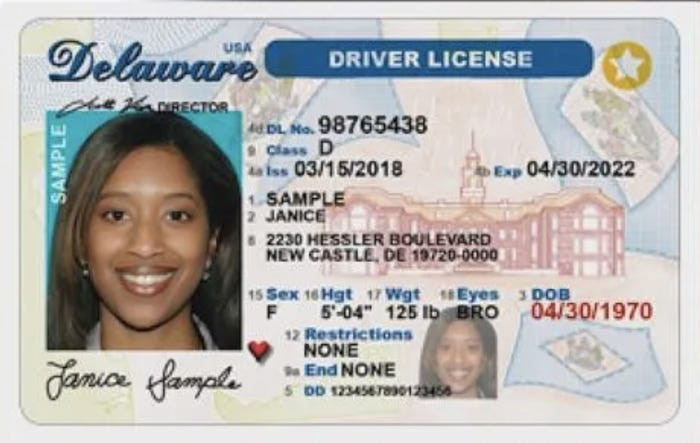
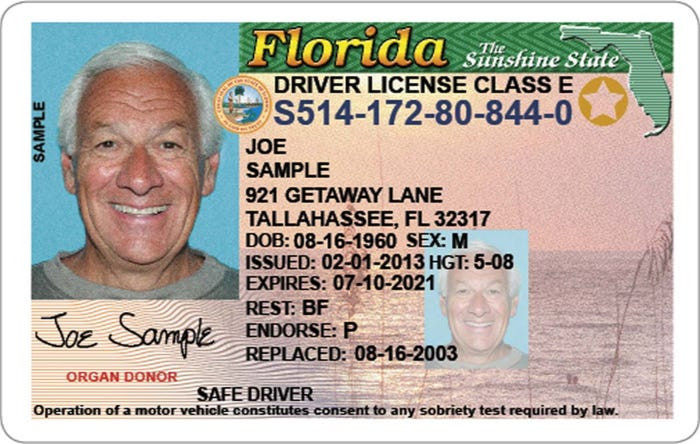
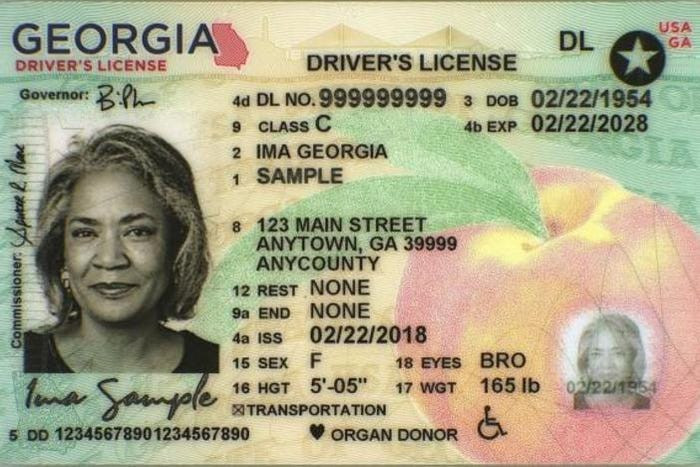

In [8]:
import json
from IPython.display import HTML, display

formatters = {
    "image": lambda x: f"<img src='{encode_image(x, format='JPEG')}' width='400'>"
}
cols = ["image_path", "image"]
display(HTML(df[cols].head(n=10).to_html(formatters=formatters, escape=False)))

Let's initialize the VLM Run Client

In [9]:
from vlmrun.client import VLMRun

client = VLMRun(base_url=VLMRUN_BASE_URL, api_key=VLMRUN_API_KEY)
client

VLMRun(base_url=https://dev.vlm.run/v1, api_key=sk-test-..., version=0.1.15)

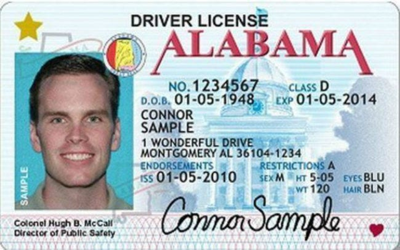

{
  "id": "3c3e60bf-5a11-4f14-850c-129855d13f99",
  "created_at": "2025-02-11T22:40:13.684910",
  "completed_at": "2025-02-11T22:40:25.364356Z",
  "response": {
    "issuing_state": "AL",
    "license_number": "1234567",
    "full_name": "CONNOR SAMPLE",
    "first_name": "CONNOR",
    "middle_name": null,
    "last_name": "SAMPLE",
    "address": {
      "street": "1 WONDERFUL DRIVE",
      "city": "MONTGOMERY",
      "state": "AL",
      "zip_code": "36104-1234"
    },
    "date_of_birth": "1948-01-05",
    "gender": "M",
    "height": "5'05\"",
    "weight": 120.0,
    "eye_color": "BLU",
    "hair_color": "BLN",
    "issue_date": "2010-01-05",
    "expiration_date": "2014-01-05",
    "license_class": "D",
    "donor": true,
    "veteran": null
  },
  "status": "completed",
  "usage": {
    "elements_processed": 1,
    "element_type": "image",
    "credits_used": 1
  }
}


In [25]:
# Display a sample image
image = df["image"][0]
W, H = image.size
display(image.resize((400, int(400 * H / W))))

# Generate the response for the sample image
response = client.image.generate(
    images=[image],
    domain="document.us-drivers-license"
)
print(response.model_dump_json(indent=2))

Let's initialize the OpenAI client to compare it with VLM Run

In [16]:
from openai import OpenAI

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", None)

if OPENAI_API_KEY is None:
    OPENAI_API_KEY = getpass.getpass()

In [17]:
openai_client = OpenAI(api_key=OPENAI_API_KEY)

We need to import the US driver license schema from the VLM Run Hub

In [18]:
from vlmrun.hub.schemas.document.us_drivers_license import USDriversLicense
from vlmrun.hub.utils import patch_response_format

# Dry run test with openai client
openai_response = openai_client.beta.chat.completions.parse(
    model="gpt-4o-mini",
    messages=[{
        "role": "user",
        "content": [
            {"type": "text", "text": "Extract the driver's license details."},
            {"type": "image_url", "image_url": {"url": encode_image(df["image"][0], format="JPEG")}}
        ],
    }],
    response_format=patch_response_format(USDriversLicense),
    temperature=0,
)

In [21]:
print(openai_response.choices[0].message.parsed.model_dump_json(indent=2))

{
  "issuing_state": "AL",
  "license_number": "1234567",
  "full_name": "CONNOR SAMPLE",
  "first_name": "CONNOR",
  "middle_name": null,
  "last_name": "SAMPLE",
  "address": {
    "street": "1 WONDERFUL DRIVE",
    "city": "MONTGOMERY",
    "state": "AL",
    "zip_code": "36104-1234"
  },
  "date_of_birth": "01-05-1948",
  "gender": "M",
  "height": "5'05\"",
  "weight": 120.0,
  "eye_color": "BLU",
  "hair_color": "BLN",
  "issue_date": "01-05-2010",
  "expiration_date": "01-05-2014",
  "license_class": "D",
  "donor": null,
  "veteran": null
}


In [27]:
from vlmrun.hub.schemas.document.us_drivers_license import USDriversLicense

def get_responses(df: pd.DataFrame) -> pd.DataFrame:
    
    def process_single_image(image):
        # Generate the response for the image using VLM Run
        vlm_response = client.image.generate(
            images=[image],
            domain="document.us-drivers-license"
        )
        # Generate the response for the image using OpenAI
        openai_response = openai_client.beta.chat.completions.parse(
            model="gpt-4o-mini",
            messages=[{
                "role": "user",
                "content": [
                    {"type": "text", "text": "Extract the driver's license details."},
                    {"type": "image_url", "image_url": {"url": encode_image(image, format="JPEG")}}
                ],
            }],
            response_format=patch_response_format(USDriversLicense),
            temperature=0,
        )
        
        return pd.Series({
            'vlm_response': vlm_response,
            'openai_response': openai_response
        })
    
    # Process all images and combine results
    responses = df['image'].apply(process_single_image)
    return pd.concat([df, responses], axis=1)

In [28]:
df_results = get_responses(df)
df_results.head()

APIError: HTTPSConnectionPool(host='dev.vlm.run', port=443): Read timed out. (read timeout=120)


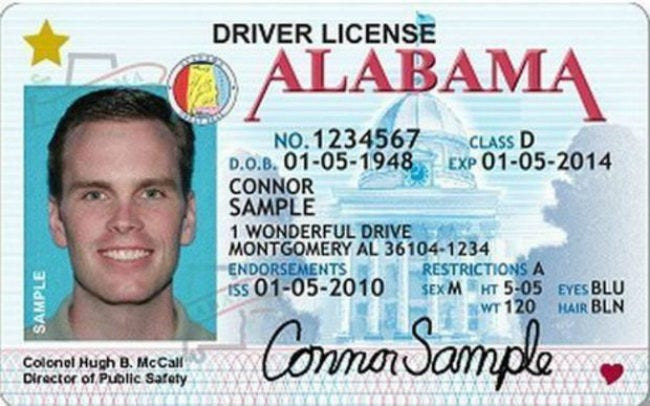
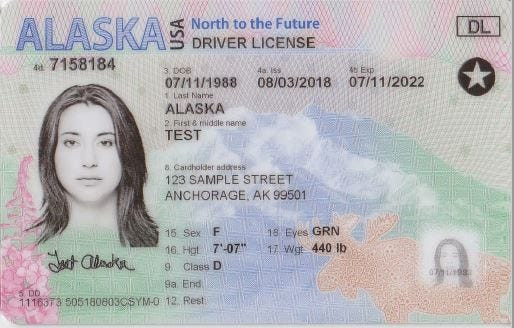
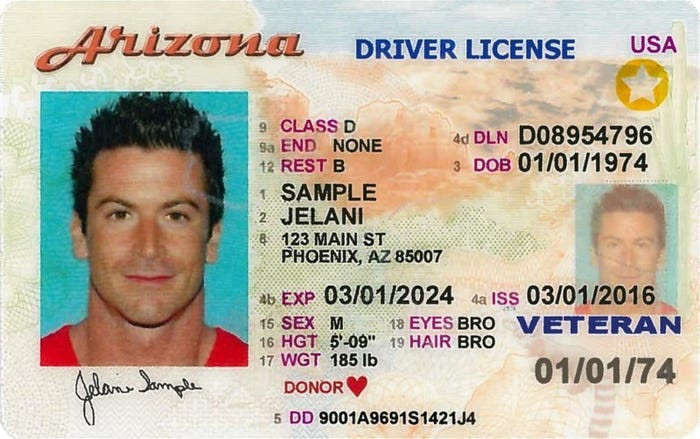
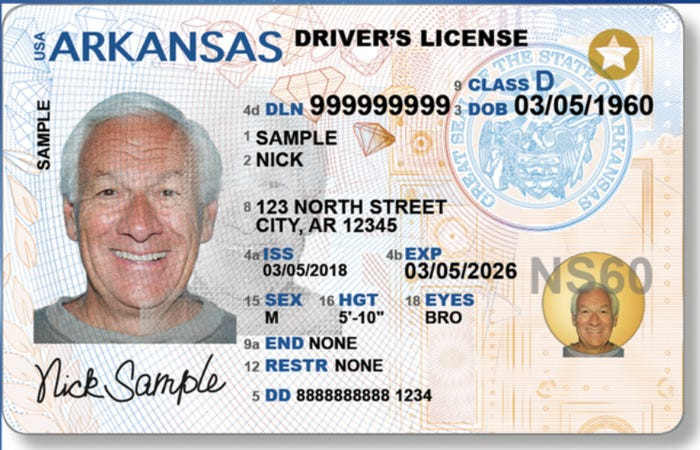
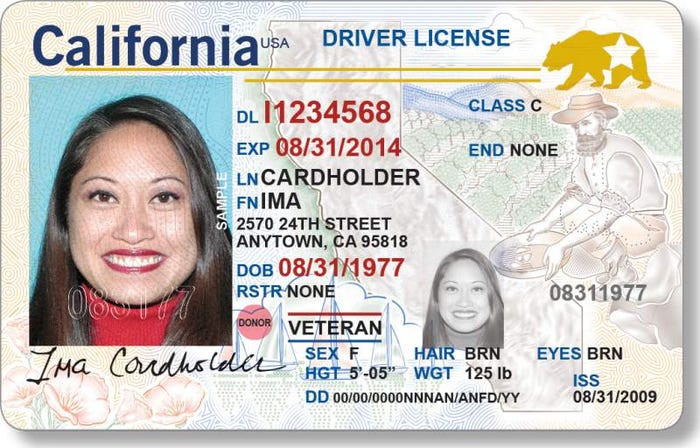
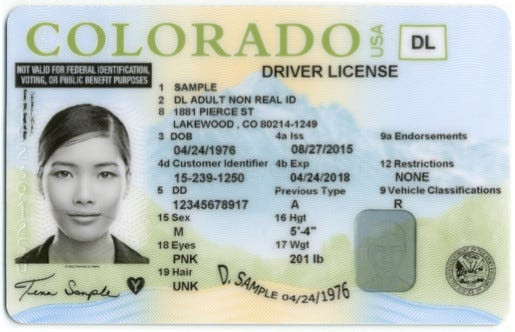
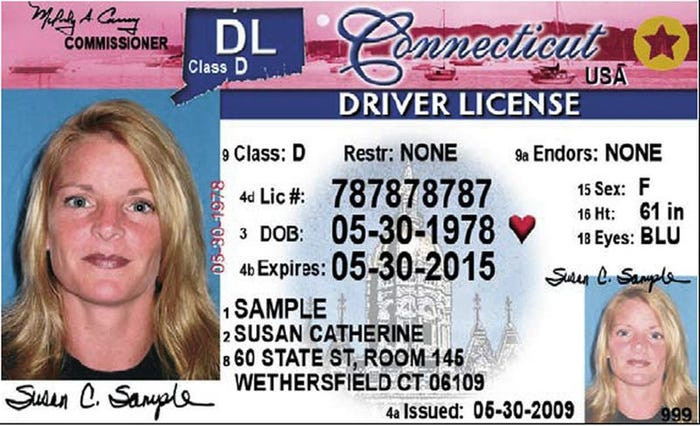
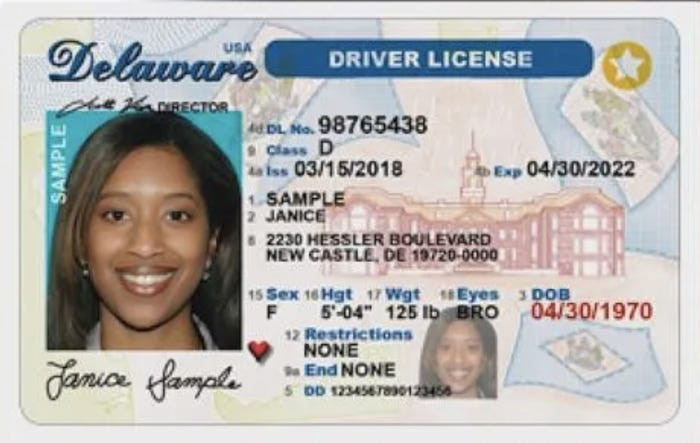
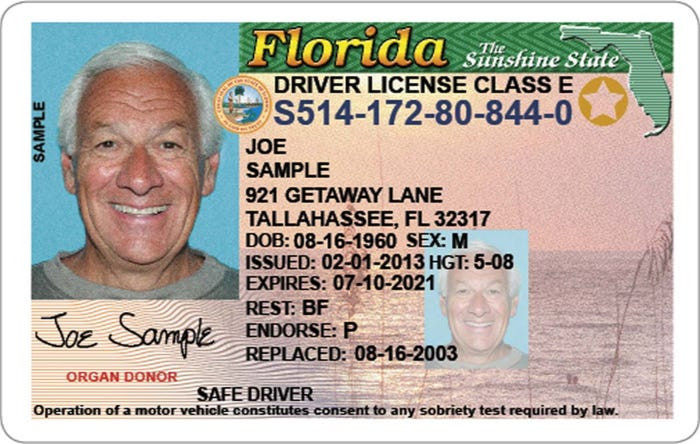
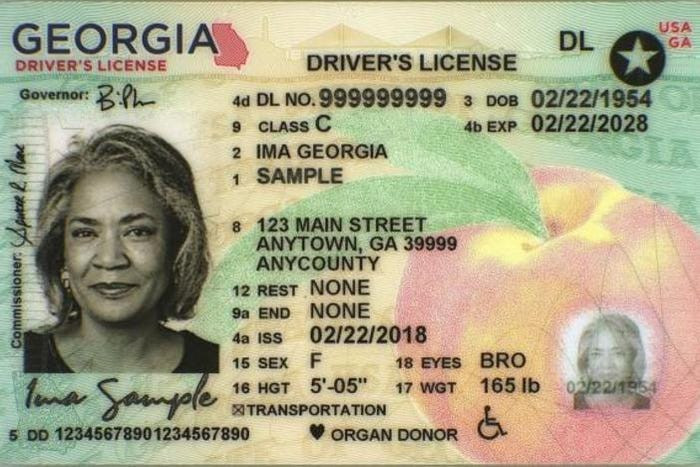

In [15]:
def format_comparison(row):
    return f"""
    <div style="border: 1px solid #ddd; padding: 15px; margin: 10px 0; border-radius: 5px;">
        <div style="display: flex; gap: 20px;">
            <div style="flex: 1;">
                <h4>Image</h4>
                <img src='{encode_image(row["image"], format="JPEG")}' width='300'>
            </div>
            <div style="flex: 2;">
                <div style="display: flex; gap: 20px;">
                    <div style="flex: 1;">
                        <h4>VLM Run</h4>
                        <pre style="background: #f5f5f5; padding: 10px; border-radius: 5px;">
{json.dumps(row["vlm_response"].response, indent=2)}</pre>
                    </div>
                    <div style="flex: 1;">
                        <h4>OpenAI</h4>
                        <pre style="background: #f5f5f5; padding: 10px; border-radius: 5px;">
{json.dumps(json.loads(row["openai_response"].choices[0].message.parsed.model_dump_json()), indent=2)}</pre>
                    </div>
                </div>
            </div>
        </div>
    </div>
    """
    
display(HTML(
    df_results.head(10).apply(format_comparison, axis=1)
    .str.cat(sep='\n')
))